# Modelo: Árbol de Decisión

https://scikit-learn.org/stable/modules/tree.html

En este notebook entrenaremos el modelo de **Árbol de Decisión**, un primer modelo simple que se caracteriza por tener un criterio de decisión similar al de un humano. El objetivo es ir formando un árbol en diferentes nodos repartiendo las instancias según los feature de nuestro dataset. El hecho de escoger el mejor feature para repartir las instancias se realizaba bajo dos diferentes criterios: Impureza de Gini ó Entropía.

En el entrenamiento de este modelo, se pasará a tener en cuenta los siguientes hiperparametros:

* criterion: es aquel criterio que comentamos de Gini o de Entropía. Probaremos los 2 en la búsqueda del mejor hiperparametro. 
* min_samples_leaf: corresponde a la cantidad de instancias mínimas que puede almacenar un nodo hoja. 
* max_depth: la profundidad máxima que puede agarrar nuestro árbol formado

Los últimos 2 hiperparámetros son demasiados importantes. 

No dejaremos que nuestro algoritmo particione demasiado, pues si nuestro árbol tiene muchísima profundidad correamos el riesgo de tener muchas ramas de nuestro árbol, por ende nos podría ocurrir el inconveniente de memorizar demasiado nuestro dataset logrando tener overfitting. En cambio, si mantenemos una máxima profundidad muy chica de 1 o 2, corremos el riesgo de tener un modelo demasiado general, es decir el sinónimo de alto sesgo: solo nos centraremos en muy pocos atributos, ignorando muchísimos otros. 

En conclusión, nos aparece el inconveniente trade-off Sesgo vs Varianza.

Para esto, limitaremos la profundidad máxima de 3 a 8 en todos los casos, como también los min samples de 50 a 100.

# Importación de librerias y datasets

Segun nuestro preprocessing.py desarollado e investigado, importaremos inicialmente la primera función necesaria para trabajar:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from preprocessing import obtener_datasets
from preprocessing import get_dataframe_polynomial

Obtendremos nuestro 2 datasets.
* df: el que usaremos para entrenar
* df_for_prediction: el que usaremos a final de todo como *holdout* para predecir. 

In [2]:
df, df_for_prediction = obtener_datasets()

Además para varios preprocesamientos que probaremos usaremos esta funcion que nos calcula el AUC-ROC para test y train, y también nos imprime los mejores hiperparámetros elegidos.

# Primer Preprocesamiento: conversion_numerica()

Como primer preprocesamiento simple primero realizaremos una preparación acorde al Análisis Exploratorio realizado en la parte 1 de este trabajo práctico, además al llamar a esta función nos devuelve el el set de entrenamiento 'X' como el set de validación 'y' de nuestra variable target a predecir (alto_valor_adquisitivo). Esta función está dentro de nuestro preprocessing.py, la importamos y aplicamos.

In [3]:
from preprocessing import aplicar_preparacion

In [4]:
X_df, y_df = aplicar_preparacion(df)
X_df.shape

(32561, 11)

Además haremos una conversión numérica debido a que en sklearn los arboles no trabajan con variables categóricas. A las categóricas con noción de orden se le asigna su numero correspondiente con OrdinalEncoder y las de sin orden se convierte en nuevas feature binarias con OneHotEncding. Esté preprocesamiento lo aplicamos con la función de 'conversion_numerica()' 

In [5]:
from preprocessing import conversion_numerica

In [6]:
X_df_numerico = conversion_numerica(X_df) 
X_df_numerico.shape

Aplicando 'conversion_numerica' en las variables categóricas.


(32561, 40)

Quedándonos 40 features respecto de las 11 posibles que teniamos.

## Entrenamiento

Dividimos nuestro dataset en train y test antes de empezar a entrenar nuestro árbol de decisión. Usaremos train para entrenar y luego con test para validar nuestro entrenamiento.

En esta división la tenemos en cuenta según el **stratify**: es decir, estamos indicándole de dividir el dataset en proporciones iguales en cuanto a la clase a predecir. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, random_state=10, test_size=0.20, stratify=y_df)

Utilizaremos GridSearchCV para la busqueda de hiperparámetros, además buscando mejorar la metrica solicitada de **auc-roc**. También, con GridSearchCV nos permite realizar cross-validation, por ende también lo aplicaremos pero de manera **Stratified** por las mismas razones mencionadas en el split de train y test.

Los hiperparametros por el que buscará GridSearchCV serán los siguientes:

In [8]:
params = {
    'max_depth': np.arange(3, 8),
    'min_samples_leaf': np.arange(50, 100, 1),
    "criterion": ["gini", "entropy"],
}

Definimos el modelo clasificador (clf) del Árbol de Decisión con el StratifiedKFold para cross-validation mencionado. Esto esto lo meteremos en  GridSearchCV:

In [9]:
clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf_1 = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)

Entrenaremos y predecimos con el X_test que obtuvimos anteriormente.

In [10]:
clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_test)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.0min finished


## Métricas

Veamos diferentes métricas con esta prediccion realizada:

In [11]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_1.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_1.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf_1.best_params_)

AUC-ROC score sobre test:  0.9013640478941830
AUC-ROC score sobre train:  0.9076413130904566
Accuracy sobre test:  0.8562874251497006
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 50}


0.9013 de AUC-ROC sobre el set de test, nada mal. Veamos diferentes métricas más:

In [12]:
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))

              precision    recall  f1-score   support

  Bajo valor       0.87      0.96      0.91      4945
  Alto valor       0.79      0.54      0.65      1568

    accuracy                           0.86      6513
   macro avg       0.83      0.75      0.78      6513
weighted avg       0.85      0.86      0.85      6513



Vemos una sutileza con el recall de alto valor. Esto además lo podemos comprobar con la matriz de confusión que construimos como función adicional en nuestro preprocessing.py, primero la importamos y luego graficamos

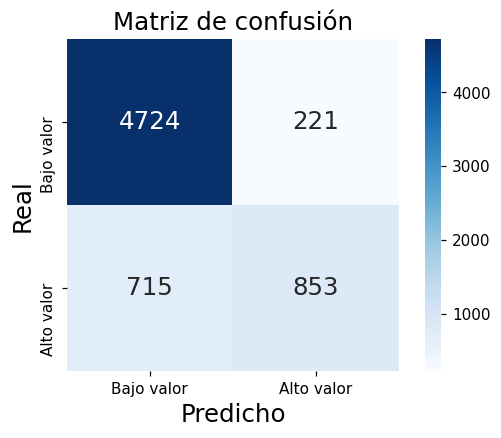

In [13]:
from preprocessing import graficar_matriz_confusion
graficar_matriz_confusion(y_test, y_pred)

Es decir, le cuesta predecir a los alto valor. Esto se nota con el bajo recall del modelo y en la diagonal de la matriz de confusión

Pero a grandes rasgos, tenemos un buen modelo que no overfittea. Mostremos su curva ROC mediante una función auxiliar tambien disponible en nuestro preprocessing.py

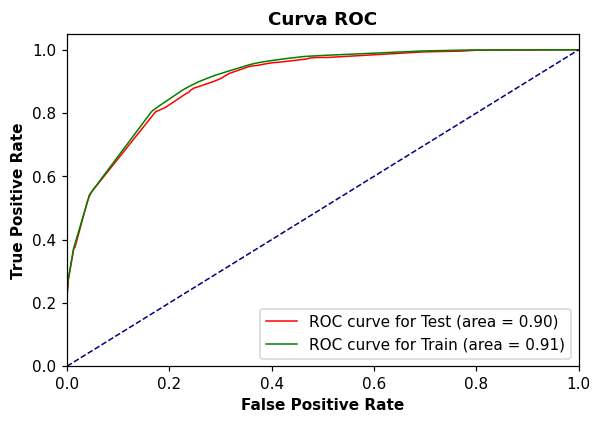

In [14]:
from preprocessing import plot_roc_curves
plot_roc_curves(clf_1, X_test, y_test, X_train, y_train)

Logrando con esto un muy buen AUC-ROC pero no un buen recall para los de alto valor. Veamos si con otros preprocesamientos esto puede ir mejorando aunque nos enfocaremos en seguir obteniendo el mejor AUC-ROC. 

La forma de entrenar, predecir y graficar resultados para los proximos preprocesamietnos será de la misma forma descripta en este primer preprocesamiento, no daremos tantos detalles tal como hicimos en este primer entrenamiento.

# Segundo Preprocesamiento: get_dataframe_polynomial()

Para este caso, buscaremos realizar una expansión del dataset mediante PolynomialFeatures. Ésto solo se aplicará para las 4 columnas numéricas que tenemos en nuestro dataset inicial:

In [15]:
df.describe()

,anios_estudiados,edad,suma_declarada_bolsa_argentina,horas_trabajo_registradas
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456
std,2.664488,13.640433,7408.986951,12.347429
min,1.000000,17.000000,-4356.000000,1.000000
25%,13.000000,28.000000,0.000000,40.000000
50%,14.000000,37.000000,0.000000,40.000000
75%,16.000000,48.000000,0.000000,45.000000
max,20.000000,90.000000,99999.000000,99.000000


Nuestra funcion desarrollada en preprocessing.py aplica solamente a estas 4 features dicha expansión. Ademas esta función le podemos decir qué grado aplicar para buscar esa expansión como tambien un booleano indicandole si se permite realizar potencias entre features. Importemos y apliquemos dicho preprocesado.

## Con PolynomialFeatures(2, interaction_only = True)

### Entrenamiento

In [16]:
X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico, 2, True)
X_df_numerico_poly.shape

Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 46 features...


(32561, 46)

Aplicar un polynomial de grado 2 con interaction_only en true en el dataset antes de dividir en train y test (también podriamos haberlo aplicado despues: acá no implicaria tener data leak puesto que PolynomialFeature agarra sample por sample y multiplica sus features segun el grado solicitado, es decir: no tiene información de las demas instancias). 
Entrenemos entonces con esto así:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico_poly, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(3, 8),
    'min_samples_leaf': np.arange(50, 100, 1),
    "criterion": ["gini", "entropy"],
}
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_r = tree.DecisionTreeClassifier(random_state=10)
clf_2_a = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)

clf_2_a.fit(X_train, y_train)
y_pred = clf_2_a.predict(X_test)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2493 out of 2500 | elapsed:  1.0min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.1min finished


### Métricas

AUC-ROC score sobre test:  0.9013201337157715
AUC-ROC score sobre train:  0.9092599894839583
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 55}


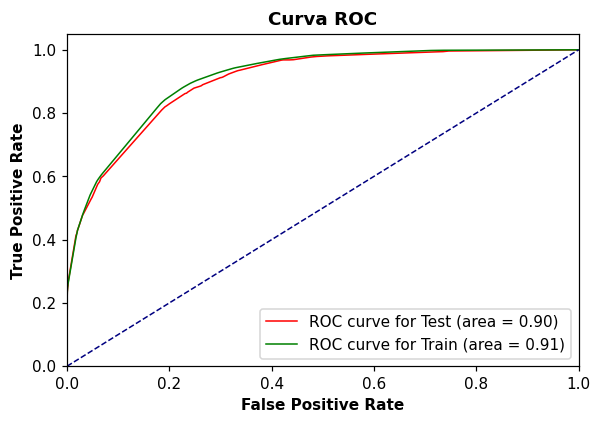

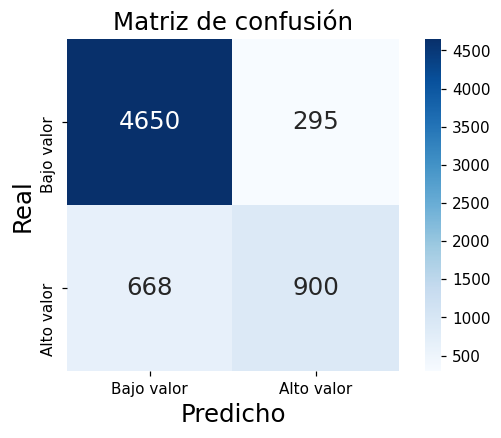

In [18]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_2_a.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_2_a.predict_proba(X_train)[:, 1]))
print("Los mejores hiperpametros elegidos: ", clf_2_a.best_params_)
plot_roc_curves(clf_2_a, X_test, y_test, X_train, y_train)
graficar_matriz_confusion(y_test, y_pred)

Lo interesante de este preprocesado es que mejoró la diagonal vista en la matriz de confusión. Es decir, miremos el reporte de métricas:

In [19]:
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))

              precision    recall  f1-score   support

  Bajo valor       0.87      0.94      0.91      4945
  Alto valor       0.75      0.57      0.65      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.76      0.78      6513
weighted avg       0.85      0.85      0.84      6513



Es decir, hubo una mejora del recall con respecto al primer preprocesamiento. Veamos con la opción de "interaction_only=False" para las potencias

## Con PolynomialFeatures(2, interaction_only = False)

### Entrenamiento

In [20]:
X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico, 2, False)
X_df_numerico_poly.shape

Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 50 features...


(32561, 50)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico_poly, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(3, 8),
    'min_samples_leaf': np.arange(50, 100, 1),
    "criterion": ["gini", "entropy"],
}
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_r = tree.DecisionTreeClassifier(random_state=10)
clf_2_b = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)

clf_2_b.fit(X_train, y_train)
y_pred = clf_2_b.predict(X_test)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2493 out of 2500 | elapsed:  1.4min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.4min finished


### Métricas

AUC-ROC score sobre test:  0.9007551175171788
AUC-ROC score sobre train:  0.9100814499481352
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 55}


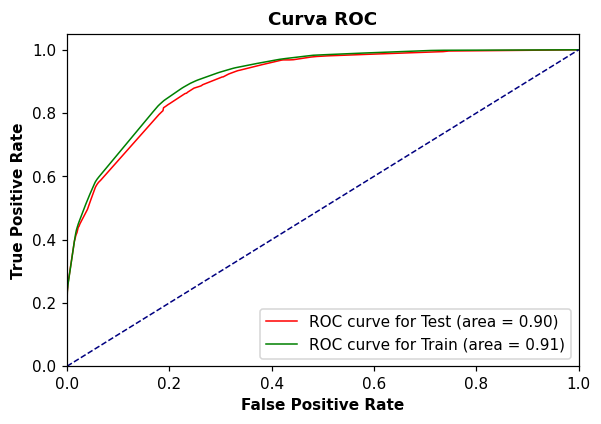

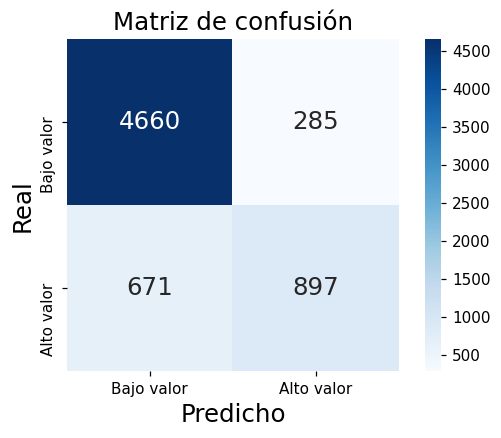

In [22]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_2_b.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_2_b.predict_proba(X_train)[:, 1]))
print("Los mejores hiperpametros elegidos: ", clf_2_b.best_params_)
plot_roc_curves(clf_2_b, X_test, y_test, X_train, y_train)
graficar_matriz_confusion(y_test, y_pred)

In [23]:
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))

              precision    recall  f1-score   support

  Bajo valor       0.87      0.94      0.91      4945
  Alto valor       0.76      0.57      0.65      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.76      0.78      6513
weighted avg       0.85      0.85      0.85      6513



Vemos claramente que el AUC-ROC empeoró. Podriamos intentar probar con diferentes grados de polinomios para expandir el dataset pero podria llegar a correr el riesgo de overfittear.

Exploremos con otros preprocesamientos para ver si mejora esto.

# Tercer Preprocesamiento: get_dataframe_scaled()

Para este tercer preprocesamiento vamos a realizar un escalado de los datos con nuestra función 'get_dataframe_scaled()' el cual requiere que le pasemos un escalador y el dataset a escalar. La misma nos devolverá el dataset escalado.

In [24]:
from preprocessing import get_dataframe_scaled
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## StandardScaler()

Empezemos con un StandardScaler que estandariza las variables teniendo en cuenta la media y varianza de las mismas.

### Entrenamiento

In [25]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

Aplicando 'conversion_numerica' en las variables categóricas.


Dividamos y entrenemos, además despues de dividir apliquemos dicho escalado para evitar **leaks**: puesto que si aplicamos al revés estariamos relleando posible informacion en el set de test con información de train ya que este tipo de escalado utiliza información de la varianza y la media de todo el dataset en sí.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, random_state=10, test_size=0.20, stratify=y_df)
X_train = get_dataframe_scaled(X_train, StandardScaler())
X_test = get_dataframe_scaled(X_test, StandardScaler())

params = {
    'max_depth': np.arange(3, 8),
    'min_samples_leaf': np.arange(50, 100, 1),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf_3_a = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)

clf_3_a.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   47.1s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fb5d1950f20>,
             estimator=DecisionTreeClassifier(random_state=10), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='roc_auc', verbose=True)

### Métricas

In [27]:
y_pred = clf_3_a.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_3_a.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_3_a.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf_3_a.best_params_)

AUC-ROC score sobre test:  0.8944635247931326
AUC-ROC score sobre train:  0.9076413130904566
Accuracy sobre test:  0.8470750806080147
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 50}


Vemos que empeoró el AUC-ROC. Veamos más métricas:

              precision    recall  f1-score   support

  Bajo valor       0.86      0.96      0.90      4945
  Alto valor       0.79      0.50      0.61      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.73      0.76      6513
weighted avg       0.84      0.85      0.83      6513



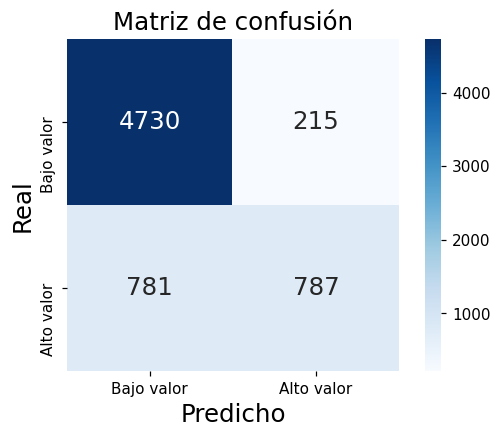

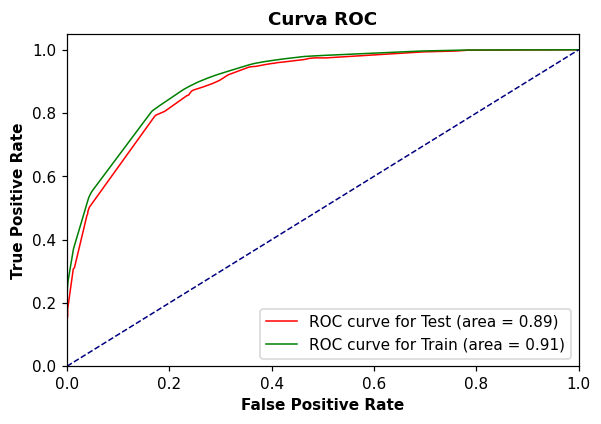

In [28]:
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_3_a, X_test, y_test, X_train, y_train)

Empeoró bastante con este preprocesamiento en cuanto al AUC-ROC conseguido en el primer preprocesado. Veamos un segundo escalado que seguramente utilizaremos muchisimo más en otros notebooks.

## MinMaxScaler()

In [29]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

Aplicando 'conversion_numerica' en las variables categóricas.


### Entrenamiento

In [30]:
from preprocessing import get_dataframe_scaled
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

params = {
    'max_depth': np.arange(3, 8),
    'min_samples_leaf': np.arange(50, 100, 1),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf_3_b = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)

clf_3_b.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 2493 out of 2500 | elapsed:   42.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   42.8s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fb5d176ea50>,
             estimator=DecisionTreeClassifier(random_state=10), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='roc_auc', verbose=True)

### Métricas

AUC-ROC score sobre test:  0.8918335749365469
AUC-ROC score sobre train:  0.9076413130904566
Accuracy sobre test:  0.8469215415323200
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 50}
              precision    recall  f1-score   support

  Bajo valor       0.86      0.95      0.90      4945
  Alto valor       0.78      0.51      0.61      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.73      0.76      6513
weighted avg       0.84      0.85      0.83      6513



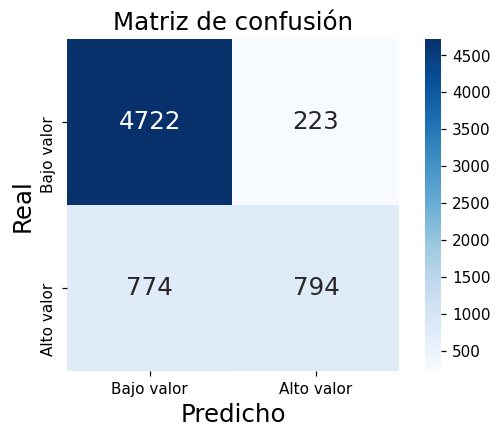

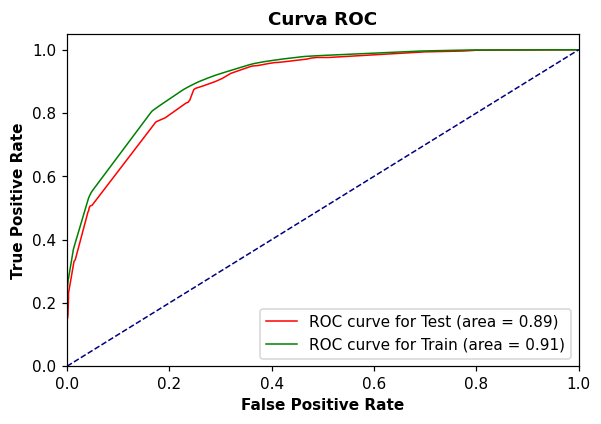

In [31]:
y_pred = clf_3_b.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf_3_b.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_3_b.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf_3_b.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_3_b, X_test, y_test, X_train, y_train)

Vemos que empeoró el auc-roc con este preprocesamiento. 

# Predicciones holdout

Habíamos visto que el mejor resultado fue el primero con un preprocesamiento simple:

In [32]:
print("Los mejores hiperpametros elegidos: ", clf_1.best_params_)

Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 50}


Importamos y apliquemos la función necesaria para aplicar la preparación en el set de holdout. Recordemos que esta función aplica internamente la función de '**aplicar_preparacion()**' o '**aplicar_preparacion_generalizado()**' según el booleano recibido.

In [33]:
from preprocessing import aplicar_preparacion_holdout

X_holdout = aplicar_preparacion_holdout(df_for_prediction, generalizada=False)

Apliquemos el procesado con el que obtuvimos el mejor score AUC-ROC:

In [34]:
X_holdout_numerico = conversion_numerica(X_holdout) 
X_holdout_numerico.shape

Aplicando 'conversion_numerica' en las variables categóricas.


(16281, 40)

Hagamos **.predict()** sobre este holdout para luego agregarlo como nueva columna en este dataset para así exportar el **.csv** con facilidad mediante Pandas. 

In [35]:
y_pred_holdout = clf_1.predict(X_holdout_numerico)
X_holdout['tiene_alto_valor_adquisitivo'] = y_pred_holdout

In [36]:
name_model = '#1 - Árbol de decisión'

if X_holdout.index[0] == 0:
    X_holdout.index += 1 
X_holdout['tiene_alto_valor_adquisitivo'].to_csv('predicciones/' + name_model + '.csv', index=True, index_label = 'id')